# Connect to a Database

In [2]:
import psycopg2
def db_connection():
    try:
        conn = psycopg2.connect(dbname='insurello',
                            host='localhost',
                            port='5432',
                            user='postgres',
                            password='postgres')
        print('connected to database')
    except:
        raise Exception("Can't connect to database, make sure you have the correct .env file \n")
    return conn

conn = db_connection()

connected to database


Typically this analysis would be done with a BI tool but for the purpose of this case we will use pandas.

In [3]:
import pandas as pd
# Test a simple query
simple_query = pd.read_sql("select * from case_data limit 5", conn)
simple_query

,case_id,event,timestamp,aggregate_type
0,125044,claim,2020-09-06 00:01:00.277,case
1,125922,claim,2020-09-09 08:18:40.970,case
2,25046,claim,2019-05-09 21:28:34.936,case
3,130529,claim,2020-09-26 17:29:42.492,case
4,246885,claim,2021-10-26 16:54:58.983,case


# Testing our database
#### How many payouts do we have per a customer?

Text(0.5, 1.0, 'Payouts per a customer')

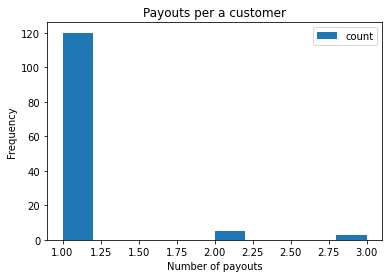

In [6]:
payouts_per_customer_query = """
with
joined_data as(
select
payout_id,
pd."insuranceCaseId",
icd.case_id,
cd."customerId" 
from payout_data pd 
left join insurance_case_data icd on pd."insuranceCaseId"  = icd."insurance_case_id"
left join customer_data cd  on icd."case_id" = cd."case_id"
)
select
"customerId",
count(*)
from joined_data
where "customerId" is not null --there are some insurance_case_ids that are orphans in the payout data table
group by "customerId"

"""
payouts_per_customer = pd.read_sql(payouts_per_customer_query, conn)

plot = payouts_per_customer.plot(kind='hist')
plot.set_xlabel("Number of payouts")
plot.set_ylabel("Frequency")
plot.set_title("Payouts per a customer")

Most customer have just one payout with some, but very few, having 2 or 3 payouts

#### how long does the customer wait between the incident until they create a claim at Insurello?”

Text(0.5, 1.0, 'Distribution of claim reporting delay')

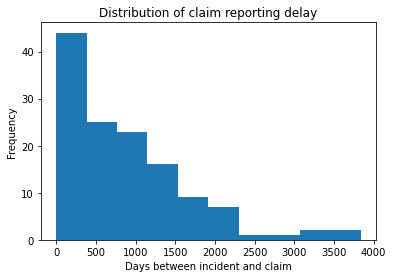

In [5]:
query_incident_till_claim = """
with
joined_data as(
select
insurance_case_Id,
icd.case_id,
incident.date_of_incident ::date,
--assume timestamp is claim date 
icd."timestamp"::date  as claim_date
from incident
left join insurance_case_data icd on icd.case_id = incident.case_id 
)
select
*
from joined_data
"""

from datetime import datetime

def days_between(d1, d2):
    d1 = datetime.strptime(d1, "%Y-%m-%d")
    d2 = datetime.strptime(d2, "%Y-%m-%d")
    return abs((d2 - d1).days)

incident_till_claim = pd.read_sql(query_incident_till_claim, conn)

incident_till_claim.claim_date = pd.to_datetime(incident_till_claim.claim_date)
incident_till_claim.date_of_incident = pd.to_datetime(incident_till_claim.date_of_incident)
incident_till_claim['day_diff'] = (incident_till_claim.claim_date - incident_till_claim.date_of_incident ).dt.days

plot = incident_till_claim['day_diff'].plot(kind='hist')
plot.set_xlabel("Days between incident and claim")
plot.set_ylabel("Frequency")
plot.set_title("Distribution of claim reporting delay")

Distribution of incident to claim time in days